### Necessary libraries
- pyreadr=0.5.2 (For converting Rdata to python dataframes)
- matplotlib (plot)
- seaborn (plot)
- pandas
- sklearn (machine learning)
- scipy (statistics)
- statsmodels=0.14.2 (statistics)

### Necessary data
- ctn0094data
- ctn0094extra


In [1]:
# Load and convert rdata into python dataframes

import pyreadr # pyreadr does not support numpy 2.x
import os
from matplotlib import pyplot as plt

# Define the directory containing the .rda files
directory = 'public.ctn0094data-main/data/' # Put all .rda files from both 0094data and 0094extra into this folder

# Initialize an empty dictionary to store the DataFrames
dataframes = {}

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.rda'):
        file_path = os.path.join(directory, filename)
        
        # Read the .rda file
        result = pyreadr.read_r(file_path)
        
        # Extract data into DataFrame
        for key in result.keys():
            dataframes[filename[:-4]] = result[key]

# Print the names and first rows of the DataFrames loaded
print("Loaded DataFrames:", dataframes.keys())
# for key in dataframes:
#     print(f'{key}:')
#     print(dataframes[key].head())

import warnings
warnings.filterwarnings('ignore')

Loaded DataFrames: dict_keys(['withdrawal_pre_post', 'fagerstrom', 'asi', 'derived_inductDelay_20230323', 'sex', 'derived_inductDelay', 'derived_weeklyOpioidPattern_20230327', 'site_masked', 'rbs', 'derived_raceEthnicity_20230912', 'everybody', 'all_drugs', 'derived_weeklyTLFBPattern_20230327', 'meta_study_length', 'meta_substance_groups_uds', 'pain', 'treatment', 'derived_weeklyOpioidPattern_20230912', 'uds_temp', 'screening_date', 'derived_inductDelay_20230912', 'randomization', 'derived_visitImputed', 'demographics', 'tlfb', 'derived_weeklyTLFBPattern', 'qol', 'outcomesCTN0094', 'first_survey', 'derived_raceEthnicity', 'derived_visitImputed_20230912', 'derived_weeklyTLFBPattern_20230912', 'visit', 'psychiatric', 'derived_visitImputed_20230324', 'withdrawal', 'detox', 'outcomesCTN0094_20230210', 'egOpioidsCTN0094', 'uds', 'derived_weeklyOpioidPattern', 'rbs_iv'])


In [2]:
# extract dataframes to specific variables

everybody = dataframes['everybody']
treatment = dataframes['treatment']
all_drugs = dataframes['all_drugs']
uds = dataframes['uds']
uds_temp = dataframes['uds_temp']
visit = dataframes['visit']
tlfb = dataframes['tlfb']
randomization = dataframes['randomization']
withdrawal = dataframes['withdrawal']
screening_date = dataframes['screening_date']
outcomesCTN0094 = dataframes['outcomesCTN0094']

In [3]:
opioid_substances = ['Morphine', 'Oxycodone', 'Fentanyl', 'Opioid', 'Heroin', 'Opium', 'Buprenorphine', 'Methadone', 
                     'Hydromorphone', 'Hydrocodone', 'Tramadol', 'Propoxyphene', 'Oxymorphone', 'Codeine', 'Merperidine', 'Nalbuphine']
prescribed_opioids = {
    "Outpatient BUP + EMM": "Buprenorphine",
    "Outpatient BUP + SMM": "Buprenorphine",
    "Outpatient BUP": "Buprenorphine",
    "Inpatient BUP": "Buprenorphine",
    "Methadone": "Methadone",
    "Inpatient NR-NTX": "Naltrexone"
}

wk_step = 7
def get_Return_By12Wk(miss_flag = 'UDS',randomization = randomization, uds = uds, everybody = everybody, uds_temp = uds_temp, visit=visit):
# Function to extract outcome words and return-to-use labels
#    patient_ids = uds_temp.who.unique()
    patient_ids = randomization.who.unique()
    outcomes = {} 
    return_to_use = {} # 4 consecutive opioid positive weeks between 3 and 12 week after randomization
    treatment_entry = {}
    prescribed_opioid_all = {}
    cnt_pos, cnt_neg = 0, 0
    for pid in patient_ids:
        proj_id = everybody[everybody.who==pid]['project'].values[0]
        ## here exclude the prescribed opioid for the patient in UDS
        randomization_pid = randomization[(randomization.who==pid)&(~randomization['when'].isna())] # for the current patient, drop the randomization record i the date ("when") is na
        if proj_id == '30': # remove Phase I in project 30 to be consistent with JAMA Psychiatry paper
            randomization_pid = randomization_pid[randomization_pid.which != '1']
#             print(randomization_pid)
        if randomization_pid.shape[0] == 0:
            continue
        random_group = randomization_pid.treatment.values[0]
        prescribed_opioid = prescribed_opioids[random_group]
        
        
        ## Detect correct range of study for different patients
        # There is no need to separately process project 30 as the phase I has been removed
        random_date = int(randomization_pid.when.values[0])
        range_start = random_date
        range_stop = 24*wk_step + range_start

        prescribed_opioid_all[pid] = prescribed_opioid
        treatment_entry[pid] = random_date
        outcome = ''
        accum_cnt = 0 # count consecutive positive UDS week
        return_to_use[pid] = 0

        output_range_start = random_date+wk_step*3
        output_range_stop = random_date+wk_step*12

        for i in range(range_start,range_stop,wk_step):
            start = i+1 # >=
            stop = min(i+wk_step+1,range_stop+1) # <
            
            visit_exist_pid = visit[(visit.who==pid)&(visit.when>=start)&(visit.when<stop)&((visit.what=='visit')|(visit.what=='final'))]
            uds_exist_pid = uds_temp[(uds_temp.who==pid)&(uds_temp.when>=start)&(uds_temp.when<stop)&(uds_temp.was_temp_ok=='1')]
            
            exist_num = uds_exist_pid.shape[0]
            if miss_flag == 'visit':
                exist_num += visit_exist_pid.shape[0]
            
            
            uds_pid = uds[(uds.who==pid)&(uds.when>=start)&(uds.when<stop)&(uds.what!=prescribed_opioid)] # extract
                
            if exist_num==0: # no UDS result at all 
                outcome+='o'
                if (i >= output_range_start) and (i < output_range_stop):
                    accum_cnt += 1
            else:

                ## consider all days in both visit and uds if 'visit' is set
                days_pid = uds_exist_pid.when.to_list()
                if miss_flag == 'visit':
                    days_pid += visit_exist_pid.when.to_list()
                days_pid = sorted(list(set(days_pid)))
                
                outcome_list = []
                for day_pid in days_pid:
                    uds_result_pid = uds_pid[uds_pid.when == day_pid].what.values
                    if len(set(uds_result_pid).intersection(set(opioid_substances))) >= 1: # positive for nonprescribed opioid
                        outcome_list.append('+')
                    else: # negative UDS result
                        outcome_list.append('-')
                    
                if len(set(outcome_list)) > 1:
                    outcome+='*'
                    if (i >= output_range_start) and (i < output_range_stop):
                        accum_cnt += 1
                elif len(set(outcome_list)) == 0:
                    outcome+='-'
                    if (i >= output_range_start) and (i < output_range_stop):
                        accum_cnt = 0
                elif outcome_list[0] == '+':
                    outcome+='+'
                    if (i >= output_range_start) and (i < output_range_stop):
                        accum_cnt += 1
                else:
                    outcome+='-'
                    if (i >= output_range_start) and (i < output_range_stop):
                        accum_cnt = 0

            if accum_cnt >= 4:
                return_to_use[pid] = 1
                
        outcomes[pid] = outcome
        if return_to_use[pid] == 1:
            cnt_pos += 1
        else:
            cnt_neg += 1
        
    print(cnt_pos,cnt_neg)
        
    return outcomes, return_to_use, treatment_entry, prescribed_opioid_all



In [4]:
outcomes_visit, return_to_use_visit, treatment_entry_visit, prescribed_opioids_visit = get_Return_By12Wk(miss_flag='visit')

1083 1116


In [5]:
def get_predictors(outcomes, return_to_use, treatment_entry, prescribed_opioid_all, dataframes=dataframes):
# function to extract predictors. Here not all predictors are extracted but the most relavant ones pointed out in the paper
    # first extract the list of patient ids
    pid = sorted(outcomes.keys())

    label = [return_to_use[id] for id in pid]
    
    dataframes['demographics'] = dataframes['demographics'].sort_values('who').reset_index(drop=True)
    
    demo_df = dataframes['demographics'].loc[dataframes['demographics'].who.isin(pid),['age','is_hispanic','race','job','is_living_stable','education','marital','is_male']]
    age,is_hispanic,race,job,is_living_stable,education,marital,is_male = [demo_df[col].tolist() for col in demo_df.columns]
    race = [ele if (ele == 'Black') or (ele == 'White') else 'Other' for ele in race]
    race_dic = {'Black': 1, 'White': 2, 'Other': 3}
    race = [race_dic[ele] for ele in race]
    is_male = [1 if ele == 'Yes' else 0 for ele in is_male]
    dataframes['everybody'] = dataframes['everybody'].sort_values('who').reset_index(drop=True)
    project = dataframes['everybody'].loc[dataframes['everybody'].who.isin(pid),'project'].values.tolist()

    Randomize = dataframes['randomization'][['who','treatment']].drop_duplicates().sort_values('who').reset_index(drop=True)
    treat = [Randomize.loc[Randomize.who==id,'treatment'].values[0] for id in pid]

    treatment_group = []
    for proj, trt in zip(project, treat):
        if proj == '30':
            treatment_group.append(3)
        elif trt == 'Inpatient NR-NTX':
            treatment_group.append(5)
        elif proj == '51':
            treatment_group.append(4)
        elif trt == 'Methadone':
            treatment_group.append(2)
        else:
            treatment_group.append(1)
    
    # rbs_iv -> heroin inject days
    rbs_iv = dataframes['rbs_iv'].sort_values('who').reset_index(drop=True)
    rbs_iv_rec = rbs_iv.loc[rbs_iv.who.isin(pid)&(rbs_iv.heroin_inject_days>0),['who','heroin_inject_days']]
    heroin_inject = [1 if id in rbs_iv_rec.who.values else 0 for id in pid]
    
    # all_drugs -> morphine- and cocaine-positive UDS results, before the treatment entry day
    uds_all_drug_list = dataframes['uds'].what.unique().tolist()
    uds_drugs = {drug:[] for drug in uds_all_drug_list}

    # first three week test. non-prescribed UDS >> Opioids, Oxycodone, Heroin, non-prescribed Methadone, non-prescribed Buprenorphine, 
    week1_drugs,week2_drugs,week3_drugs = {},{},{}

    # tlfb to use the self-reported drug use in the past 4 weeks

    tlfb_drugs = {'Heroin': [],'THC': [], 'Alcohol': [], 'Cocaine': [], 'Methadone': [], 'Amphetamine': []}

    tlfb_all_drugs = sorted(dataframes['tlfb'].what.unique().tolist())
    for drug in uds_drugs:
        drug_n = drug + '_uds'
        week1_drugs[drug_n] = []
        week2_drugs[drug_n] = []
        week3_drugs[drug_n] = []
    for drug in tlfb_all_drugs:
        drug_n = drug + '_tlfb'
        week1_drugs[drug_n] = []
        week2_drugs[drug_n] = []
        week3_drugs[drug_n] = []
        
    for id in pid:
        entry_day = treatment_entry[id]

        tlfb_start_day = entry_day - 7*4

        for drug in tlfb_drugs.keys():
            tlfb_id_tab = dataframes['tlfb'][(dataframes['tlfb'].who==id)&(dataframes['tlfb'].what==drug)&(dataframes['tlfb'].when>tlfb_start_day)&(dataframes['tlfb'].when<=entry_day)]
            tlfb_drugs[drug].append(tlfb_id_tab.shape[0])


        for drug in uds_drugs.keys():
            uds_id = dataframes['all_drugs'][(dataframes['all_drugs'].who==id)&(dataframes['all_drugs'].what==drug)&(dataframes['all_drugs'].when<=entry_day)&(dataframes['all_drugs'].when>=0)]
            if uds_id.shape[0] > 0:
                uds_drugs[drug].append(1)
            else:
                uds_drugs[drug].append(0)

        prescribed_opioid = prescribed_opioid_all[id]

        # weekly UDS results
        uds_week1 = dataframes['uds'][(dataframes['uds'].who==id)&(dataframes['uds'].when<=entry_day+7*1)&(dataframes['uds'].when>entry_day+7*0)]
        uds_week2 = dataframes['uds'][(dataframes['uds'].who==id)&(dataframes['uds'].when<=entry_day+7*2)&(dataframes['uds'].when>entry_day+7*1)]
        uds_week3 = dataframes['uds'][(dataframes['uds'].who==id)&(dataframes['uds'].when<=entry_day+7*3)&(dataframes['uds'].when>entry_day+7*2)]

        uds_week1_sum = outcomes[id][0]
        uds_week2_sum = outcomes[id][1]
        uds_week3_sum = outcomes[id][2]
        for drug in uds_drugs:
            drug_n = drug + '_uds'
            if uds_week1_sum == 'o':
                week1_drugs[drug_n].append(-1)
            else:
                if drug in uds_week1.what.values:
                    week1_drugs[drug_n].append(1)
                else:
                    week1_drugs[drug_n].append(0)

            if uds_week2_sum == 'o':
                week2_drugs[drug_n].append(-1)
            else:
                if drug in uds_week2.what.values:
                    week2_drugs[drug_n].append(1)
                else:
                    week2_drugs[drug_n].append(0)

            if uds_week3_sum == 'o':
                week3_drugs[drug_n].append(-1)
            else:
                if drug in uds_week3.what.values:
                    week3_drugs[drug_n].append(1)
                else:
                    week3_drugs[drug_n].append(0)

        # weekly tlfb results
        tlfb_week1 = dataframes['tlfb'][(dataframes['tlfb'].who==id)&(dataframes['tlfb'].when<=entry_day+7*1)&(dataframes['tlfb'].when>entry_day+7*0)]
        tlfb_week2 = dataframes['tlfb'][(dataframes['tlfb'].who==id)&(dataframes['tlfb'].when<=entry_day+7*2)&(dataframes['tlfb'].when>entry_day+7*1)]
        tlfb_week3 = dataframes['tlfb'][(dataframes['tlfb'].who==id)&(dataframes['tlfb'].when<=entry_day+7*3)&(dataframes['tlfb'].when>entry_day+7*2)]

        tlfb_week1_sum = outcomes[id][0]
        tlfb_week2_sum = outcomes[id][1]
        tlfb_week3_sum = outcomes[id][2]
        
        for drug in tlfb_all_drugs:
            drug_n = drug + '_tlfb'
            if tlfb_week1_sum == 'o':
                week1_drugs[drug_n].append(-1)
            else:
                if drug in tlfb_week1.what.values:
                    week1_drugs[drug_n].append(1)
                else:
                    week1_drugs[drug_n].append(0)

            if tlfb_week2_sum == 'o':
                week2_drugs[drug_n].append(-1)
            else:
                if drug in tlfb_week2.what.values:
                    week2_drugs[drug_n].append(1)
                else:
                    week2_drugs[drug_n].append(0)

            if tlfb_week3_sum == 'o':
                week3_drugs[drug_n].append(-1)
            else:
                if drug in tlfb_week3.what.values:
                    week3_drugs[drug_n].append(1)
                else:
                    week3_drugs[drug_n].append(0)

    res = [pid, label, treatment_group, age,race,is_male, heroin_inject]
    res_names = ['who', 'return_to_use', 'treatment_group', 'age','race','is_male', 'heroin_inject']
    
    for drug in tlfb_drugs.keys():
        res.append(tlfb_drugs[drug])
        res_names.append(f'TLFB_{drug}')

    for drug in uds_drugs.keys():
        res.append(uds_drugs[drug])
        res_names.append(f'UDS_{drug}')
    
    for drug in uds_drugs:
        drug_n = drug + '_uds'
        res.append(week1_drugs[drug_n])
        res_names.append(f'{drug_n}_week1')
        res.append(week2_drugs[drug_n])
        res_names.append(f'{drug_n}_week2')
        res.append(week3_drugs[drug_n])
        res_names.append(f'{drug_n}_week3')
    for drug in tlfb_all_drugs:
        drug_n = drug + '_tlfb'
        res.append(week1_drugs[drug_n])
        res_names.append(f'{drug_n}_week1')
        res.append(week2_drugs[drug_n])
        res_names.append(f'{drug_n}_week2')
        res.append(week3_drugs[drug_n])
        res_names.append(f'{drug_n}_week3')

    return res, res_names

In [6]:
res_visit, res_names_visit = get_predictors(outcomes_visit, return_to_use_visit, treatment_entry_visit, prescribed_opioids_visit)

In [7]:
import pandas as pd
res_df_visit = pd.DataFrame(res_visit).T
res_df_visit.columns = res_names_visit
print(res_df_visit.return_to_use.sum())
res_df_visit

1083.0


,who,return_to_use,treatment_group,age,race,is_male,heroin_inject,TLFB_Heroin,TLFB_THC,TLFB_Alcohol,...,Pseudoephedrine_tlfb_week3,Sedatives_tlfb_week1,Sedatives_tlfb_week2,Sedatives_tlfb_week3,THC_tlfb_week1,THC_tlfb_week2,THC_tlfb_week3,Unknown_tlfb_week1,Unknown_tlfb_week2,Unknown_tlfb_week3
0,3.0,1.0,4.0,23.0,1.0,0.0,1.0,7.0,0.0,0.0,...,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0
1,4.0,0.0,5.0,19.0,2.0,1.0,1.0,2.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,1.0,5.0,33.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,1.0,5.0,25.0,1.0,0.0,1.0,1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,10.0,1.0,1.0,29.0,3.0,0.0,1.0,27.0,0.0,0.0,...,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,3556.0,0.0,3.0,56.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0
2195,3557.0,1.0,1.0,31.0,2.0,1.0,1.0,12.0,18.0,0.0,...,-1.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,0.0,-1.0
2196,3558.0,0.0,2.0,27.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,-1.0,0.0,0.0
2197,3559.0,1.0,5.0,34.0,3.0,1.0,1.0,6.0,16.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0


In [8]:
feature_set1 = res_df_visit.columns[3:].tolist()
feature_set3 = [ele for ele in feature_set1 if not 'week' in ele]
print(len(feature_set1),len(feature_set3))

146 20


In [9]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


# Define the target for stratification
stratify_column = res_df_visit['treatment_group'].astype(str) + '_' + res_df_visit['return_to_use'].astype(str)

auc_visit, auc_train_visit = [], []

for random_seed in range(1000):

    # Perform the train-test split with stratification
    train_df_visit, test_df_visit = train_test_split(
        res_df_visit,
        test_size=549,  # specifying the exact size for the test set
        stratify=stratify_column,
        random_state=random_seed  # for reproducibility
    )
    
    # Define the features and target
    X_train = train_df_visit[feature_set1].values.astype(float)
    y_train = train_df_visit['return_to_use'].values.astype(int)
    
    X_test = test_df_visit[feature_set1].values.astype(float)
    y_test = test_df_visit['return_to_use'].values.astype(int)
    
    # Initialize the Logistic Regression model
    model = LogisticRegressionCV(random_state=random_seed, cv=5, max_iter=1000)
    
    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict the target on the training set
    y_train_pred = model.predict(X_train)
    
    # Predict the target on the test set
    y_pred = model.predict(X_test)
    
    # Predict the probabilities for ROC AUC calculation
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Predict the probabilities for ROC AUC calculation
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    
    # # Evaluate the model
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)
    auc_visit.append(roc_auc)
    auc_train_visit.append(roc_auc_train)

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


# Define the target for stratification
stratify_column = res_df_visit['treatment_group'].astype(str) + '_' + res_df_visit['return_to_use'].astype(str)

auc_visit_no3wk, auc_train_visit_no3wk = [], []

for random_seed in range(1000):

    # Perform the train-test split with stratification
    train_df_visit, test_df_visit = train_test_split(
        res_df_visit,
        test_size=549,  # specifying the exact size for the test set
        stratify=stratify_column,
        random_state=random_seed  # for reproducibility
    )
    
    # Define the features and target
    X_train = train_df_visit[feature_set3].values.astype(float)
    y_train = train_df_visit['return_to_use'].values.astype(int)
    
    X_test = test_df_visit[feature_set3].values.astype(float)
    y_test = test_df_visit['return_to_use'].values.astype(int)
    
    # Initialize the Logistic Regression model
    model = LogisticRegressionCV(random_state=random_seed, cv=5, max_iter=1000)
    
    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict the target on the training set
    y_train_pred = model.predict(X_train)
    
    # Predict the target on the test set
    y_pred = model.predict(X_test)
    
    # Predict the probabilities for ROC AUC calculation
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Predict the probabilities for ROC AUC calculation
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    
    # # Evaluate the model
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)
    auc_visit_no3wk.append(roc_auc)
    auc_train_visit_no3wk.append(roc_auc_train)

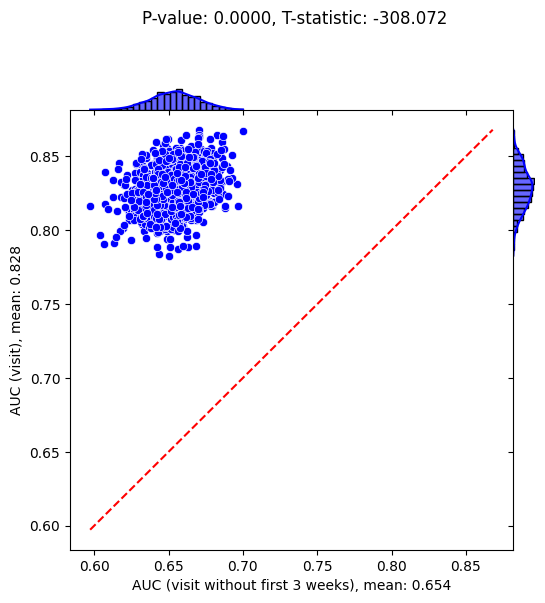

In [11]:
import seaborn as sns

# Example lists
list1 = auc_visit_no3wk
list2 = auc_visit
import numpy as np
from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(auc_visit_no3wk, auc_visit)
# Create a JointGrid with scatter plot in the center and histograms on the margins
g = sns.JointGrid(x=list1, y=list2, space=0, height=6, ratio=20)

# Scatter plot in the center
g.plot_joint(sns.scatterplot, color="blue")

# Add histograms to the margins
g.plot_marginals(sns.histplot, kde=True, color="blue", alpha=0.6)

# Add a diagonal line
min_val = min(min(list1), min(list2))
max_val = max(max(list1), max(list2))
g.ax_joint.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Set labels and title
g.set_axis_labels(f'AUC (visit without first 3 weeks), mean: {np.mean(list1):.3f}', f'AUC (visit), mean: {np.mean(list2):.3f}')
plt.suptitle(f'P-value: {p_value:.4f}, T-statistic: {t_statistic:.3f}', y=1.01)
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
# test performance with Random Forest model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the target for stratification
stratify_column = res_df_visit['treatment_group'].astype(str) + '_' + res_df_visit['return_to_use'].astype(str)

auc_visit_rf, auc_train_visit_rf = [], []

coef_dic = {}
for feat in feature_set1:
    coef_dic[feat] = 0
split_random_lst = []
for random_seed in range(1000):

    # Perform the train-test split with stratification
    train_df_visit, test_df_visit = train_test_split(
        res_df_visit,
        test_size=549,  # specifying the exact size for the test set
        stratify=stratify_column,
        random_state=random_seed  # for reproducibility
    )
    split_random_lst.append(train_df_visit.who.tolist())
    
    # Define the features and target
    X_train = train_df_visit[feature_set1].values.astype(float)
    y_train = train_df_visit['return_to_use'].values.astype(int)
    
    X_test = test_df_visit[feature_set1].values.astype(float)
    y_test = test_df_visit['return_to_use'].values.astype(int)


    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=100,  # Number of trees in the forest
        random_state=random_seed,   # Seed for reproducibility
        max_depth=None,    # Maximum depth of the tree (None means nodes are expanded until all leaves are pure)
        min_samples_split=2,  # Minimum number of samples required to split an internal node
        min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node
        n_jobs=-1  # Use all available cores
    )
    
    # Train the model on the training data
    rf_model.fit(X_train_scaled, y_train)

    # Predict the target on the training set
    y_train_pred = rf_model.predict(X_train_scaled)
    
    # Predict the target on the test set
    y_pred = rf_model.predict(X_test_scaled)
    
    # Predict the probabilities for ROC AUC calculation
    y_pred_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Predict the probabilities for ROC AUC calculation
    y_train_pred_prob = rf_model.predict_proba(X_train_scaled)[:, 1]
    
    # # Evaluate the model
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)
    auc_visit_rf.append(roc_auc)
    auc_train_visit_rf.append(roc_auc_train)

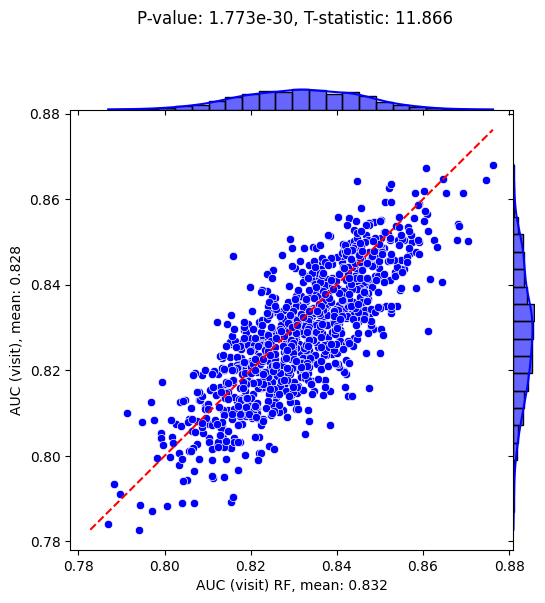

In [13]:
import seaborn as sns

# Example lists
list1 = auc_visit_rf
list2 = auc_visit

import numpy as np
from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(auc_visit_rf, auc_visit)
# print(f"T-statistic: {t_statistic:.4f}")
# print(f"P-value: {p_value}")

# Create a JointGrid with scatter plot in the center and histograms on the margins
g = sns.JointGrid(x=list1, y=list2, space=0, height=6, ratio=20)

# Scatter plot in the center
g.plot_joint(sns.scatterplot, color="blue")

# Add histograms to the margins
g.plot_marginals(sns.histplot, kde=True, color="blue", alpha=0.6)

# Add a diagonal line
min_val = min(min(list1), min(list2))
max_val = max(max(list1), max(list2))
g.ax_joint.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Set labels and title
g.set_axis_labels(f'AUC (visit) RF, mean: {np.mean(list1):.3f}', f'AUC (visit), mean: {np.mean(list2):.3f}')
plt.suptitle(f'P-value: {p_value:.4g}, T-statistic: {t_statistic:.3f}', y=1.01)
plt.show()

In [14]:
## Check importance of different features when using the first-3-week features

import statsmodels.api as sm

# Add a constant (intercept) to the model
X_train_const = sm.add_constant(res_df_visit[feature_set1].abs())
y_train = res_df_visit['return_to_use']
# Fit the OLS (Ordinary Least Squares) regression model
model = sm.OLS(y_train, X_train_const).fit()

# # Print the summary of the regression results
# print(model.summary())

# Extract the summary table as a DataFrame
summary_df = pd.DataFrame({
    'coefficients': model.params,
    'p-values': model.pvalues,
    't-values': model.tvalues,
    'std_err': model.bse,
    '95% CI Lower': model.conf_int()[0],
    '95% CI Upper': model.conf_int()[1]
})

# Sort the DataFrame by p-values
sorted_summary_df = summary_df.sort_values(by='p-values')
pd.set_option('display.max_rows', None)
# Display the sorted summary table
sorted_summary_df

,coefficients,p-values,t-values,std_err,95% CI Lower,95% CI Upper
Opioid_uds_week3,2.092721e-01,3.941125e-11,6.641561,3.150948e-02,1.474790e-01,2.710652e-01
Opioid_uds_week2,1.624205e-01,2.006054e-08,5.633265,2.883239e-02,1.058774e-01,2.189635e-01
Heroin_tlfb_week3,1.421498e-01,1.335730e-04,3.826881,3.714509e-02,6.930479e-02,2.149949e-01
Opioid_uds_week1,8.693159e-02,3.707052e-03,2.905331,2.992141e-02,2.825286e-02,1.456103e-01
Antipsychotic_tlfb_week3,-7.482906e-01,9.541214e-03,-2.594412,2.884239e-01,-1.313917e+00,-1.826640e-01
Cocaine_uds_week3,8.834816e-02,1.488514e-02,2.437173,3.625026e-02,1.725796e-02,1.594384e-01
Mdma/Hallucinogen_tlfb_week3,1.205652e+00,1.766165e-02,2.374511,5.077476e-01,2.099111e-01,2.201394e+00
heroin_inject,6.599412e-02,1.883724e-02,2.350561,2.807591e-02,1.093460e-02,1.210536e-01
Heroin_tlfb_week2,8.273697e-02,1.967157e-02,2.334345,3.544334e-02,1.322922e-02,1.522447e-01
Methadone_tlfb_week1,3.486858e-01,2.442024e-02,2.252079,1.548284e-01,4.505262e-02,6.523190e-01


In [15]:
## Check importance of different features when not using the first-3-week features

import statsmodels.api as sm

# Add a constant (intercept) to the model
X_train_const = sm.add_constant(res_df_visit[feature_set3].abs())
y_train = res_df_visit['return_to_use']
# Fit the OLS (Ordinary Least Squares) regression model
model = sm.OLS(y_train, X_train_const).fit()

# # Print the summary of the regression results
# print(model.summary())

# Extract the summary table as a DataFrame
summary_df = pd.DataFrame({
    'coefficients': model.params,
    'p-values': model.pvalues,
    't-values': model.tvalues,
    'std_err': model.bse,
    '95% CI Lower': model.conf_int()[0],
    '95% CI Upper': model.conf_int()[1]
})

# Sort the DataFrame by p-values
sorted_summary_df = summary_df.sort_values(by='p-values')
pd.set_option('display.max_rows', None)
# Display the sorted summary table
sorted_summary_df

,coefficients,p-values,t-values,std_err,95% CI Lower,95% CI Upper
heroin_inject,0.149730,0.000003,4.659265,0.032136,0.086710,0.212751
UDS_Opioid,0.113893,0.000017,4.309391,0.026429,0.062064,0.165721
TLFB_Heroin,0.004464,0.001399,3.198930,0.001395,0.001727,0.007200
const,0.214205,0.001404,3.197918,0.066983,0.082849,0.345562
UDS_Cocaine,0.080234,0.003078,2.963157,0.027077,0.027134,0.133333
TLFB_Methadone,0.008473,0.010468,2.562179,0.003307,0.001988,0.014959
TLFB_Alcohol,-0.006284,0.016917,-2.390352,0.002629,-0.011440,-0.001129
age,-0.001655,0.107328,-1.610982,0.001027,-0.003670,0.000360
is_male,0.031598,0.153594,1.427448,0.022136,-0.011812,0.075007
UDS_Alcohol,-0.056645,0.212287,-1.247666,0.045401,-0.145680,0.032389
